# QLoRA Training on Mistral for NER

by Benjamin Kissinger & Andreas Sünder

## Setup

## Load Dataset

In [1]:
%pip install -q -U bitsandbytes
%pip install -q -U git+https://github.com/huggingface/transformers.git
%pip install -q -U git+https://github.com/huggingface/peft.git
%pip install -q -U git+https://github.com/huggingface/accelerate.git
%pip install -q -U datasets scipy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [8]:
%pip install -q -U matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [3]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='train.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='val.jsonl', split='train')

## Prompt Formatting

In [1]:
def formatting_func(example):
    text = f"### Question: {example['prompt']}\n ### Answer: {example['response']}"
    return text

## Load Base Model

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-Instruct-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, torch_dtype=torch.float16, device_map="auto")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Setup Tokenization

In [4]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

In [5]:
def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))
    
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

import matplotlib.pyplot as plt

def plot_data_lengths(tokenize_train_dataset, tokenized_test_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_test_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

252


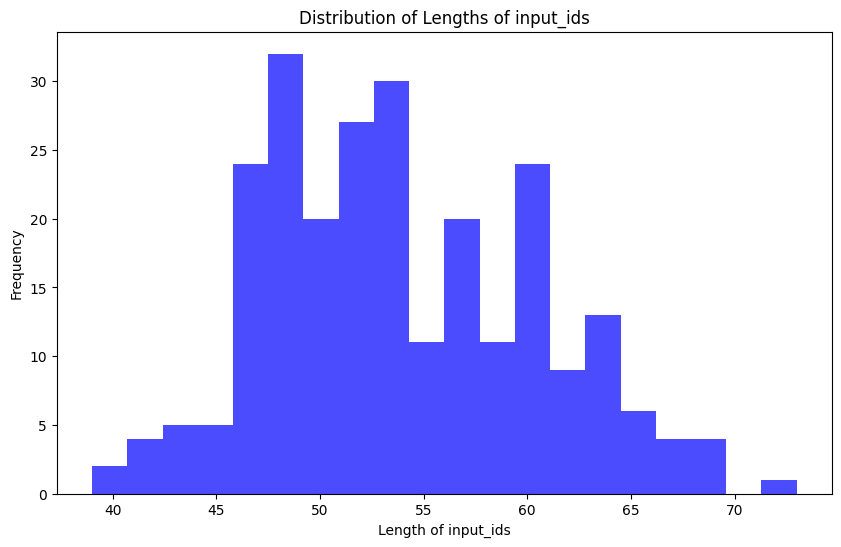

In [6]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [7]:
max_length = 55 # This was an appropriate max length for the dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [8]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

252


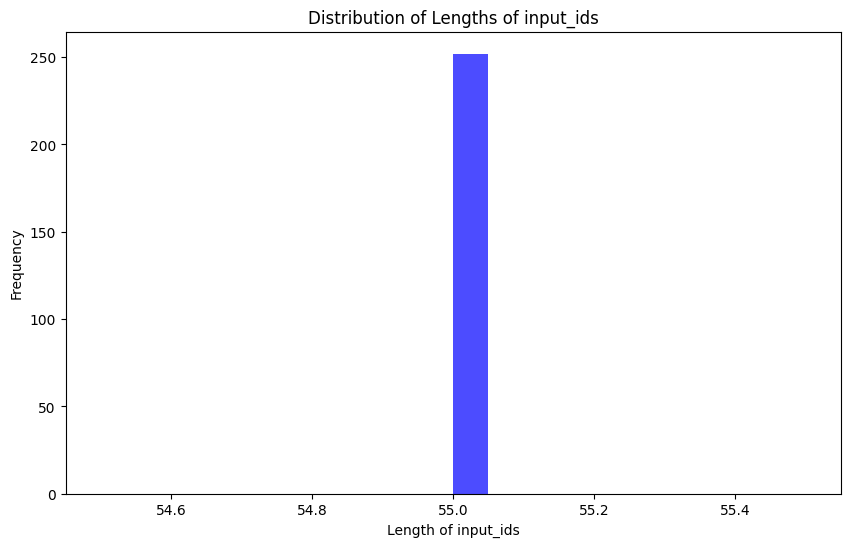

In [9]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [10]:
print(tokenized_train_dataset[0])

{'prompt': 'This text, written by Lisa Taylor, was published on 10th October 2021.', 'response': '{"author": "Lisa Taylor", "date": "2021"}', 'input_ids': [2, 2, 2, 2, 2, 2, 2, 1, 774, 22478, 28747, 851, 2245, 28725, 4241, 486, 18999, 11285, 28725, 403, 4775, 356, 28705, 28740, 28734, 362, 4527, 28705, 28750, 28734, 28750, 28740, 28723, 13, 774, 26307, 28747, 9830, 6239, 1264, 345, 28758, 7682, 11285, 548, 345, 1408, 1264, 345, 28750, 28734, 28750, 28740, 17395, 2], 'attention_mask': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [2, 2, 2, 2, 2, 2, 2, 1, 774, 22478, 28747, 851, 2245, 28725, 4241, 486, 18999, 11285, 28725, 403, 4775, 356, 28705, 28740, 28734, 362, 4527, 28705, 28750, 28734, 28750, 28740, 28723, 13, 774, 26307, 28747, 9830, 6239, 1264, 345, 28758, 7682, 11285, 548, 345, 1408, 1264, 345, 28750, 28734, 28750, 28740, 17395, 2]}


## Setup LoRA

In [11]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model.enable_input_require_grads()
model = prepare_model_for_kbit_training(model)

In [12]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [13]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=24,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.2,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 42520576 || all params: 3794591744 || trainable%: 1.1205573318192514


## Run Training

In [ ]:
import transformers
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from datetime import datetime

project = "journal-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=6,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=2e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        load_best_model_at_end=True,  # Load the best model at the end of training
        metric_for_best_model='loss',  # Use loss to determine the best model
        greater_is_better=False,       # Lower loss indicates a better model
        # report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional),
        
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  # Stop after 3 evaluations without improvement
)

model.config.use_cache = True  # silence the warnings. Please re-enable for inference!
trainer.train()

Step,Training Loss,Validation Loss
25,1.511100,1.212535
50,0.971100,0.855308
75,0.704600,0.705633
100,0.582500,0.627294
125,0.465000,0.620377
150,0.407000,0.656433


/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

## Push to hub

In [15]:
model.push_to_hub("textminr/mistral-7b-4bit-ner")

adapter_model.safetensors:   0%|          | 0.00/170M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/textminr/mistral-7b-4bit-ner/commit/53aaf6d0c349c788e55e4585e7636dad46aeb129', commit_message='Upload model', commit_description='', oid='53aaf6d0c349c788e55e4585e7636dad46aeb129', pr_url=None, pr_revision=None, pr_num=None)